<a href="https://colab.research.google.com/github/MKangabire/Water_potability/blob/AROMA/Water_Quality_Classification_Model_Using_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [251]:
# ==============================
# 1. Import Libraries
# ==============================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

In [252]:
# ==============================
# 2. Data Loading and Inspection
# ==============================
url = '/content/water_potability.csv'
dataset = pd.read_csv(url)

In [253]:
# Inspect Dataset
print("First Few Rows of the Dataset:")
print(dataset.head())
print("Dataset Shape:", dataset.shape)
print("Dataset Info:")
dataset.info()

First Few Rows of the Dataset:
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
Dataset Shape: (3276, 10)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (

In [254]:
# Check for Null Values
print("Checking for Null Values:")
print(dataset.isnull().sum())

Checking for Null Values:
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


In [255]:
# Handle Null Values
dataset = dataset.fillna(dataset.mean(numeric_only=True))

In [256]:
# Check for Duplicates
print("Duplicates:", dataset.duplicated().sum())

Duplicates: 0


In [257]:
# Dataset Info After Handling Null Values
print("Dataset Info After Handling Null Values:")
dataset.info()

Dataset Info After Handling Null Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [258]:
# Statistical Summary
print("Statistical Summary:")
print(dataset.describe())

Statistical Summary:
                ph     Hardness        Solids  Chloramines      Sulfate  \
count  3276.000000  3276.000000   3276.000000  3276.000000  3276.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.469956    32.879761   8768.570828     1.583085    36.142612   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.277673   176.850538  15666.690297     6.127421   317.094638   
50%       7.080795   196.967627  20927.833607     7.130299   333.775777   
75%       7.870050   216.667456  27332.762127     8.114887   350.385756   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3276.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        15.769881     0.7

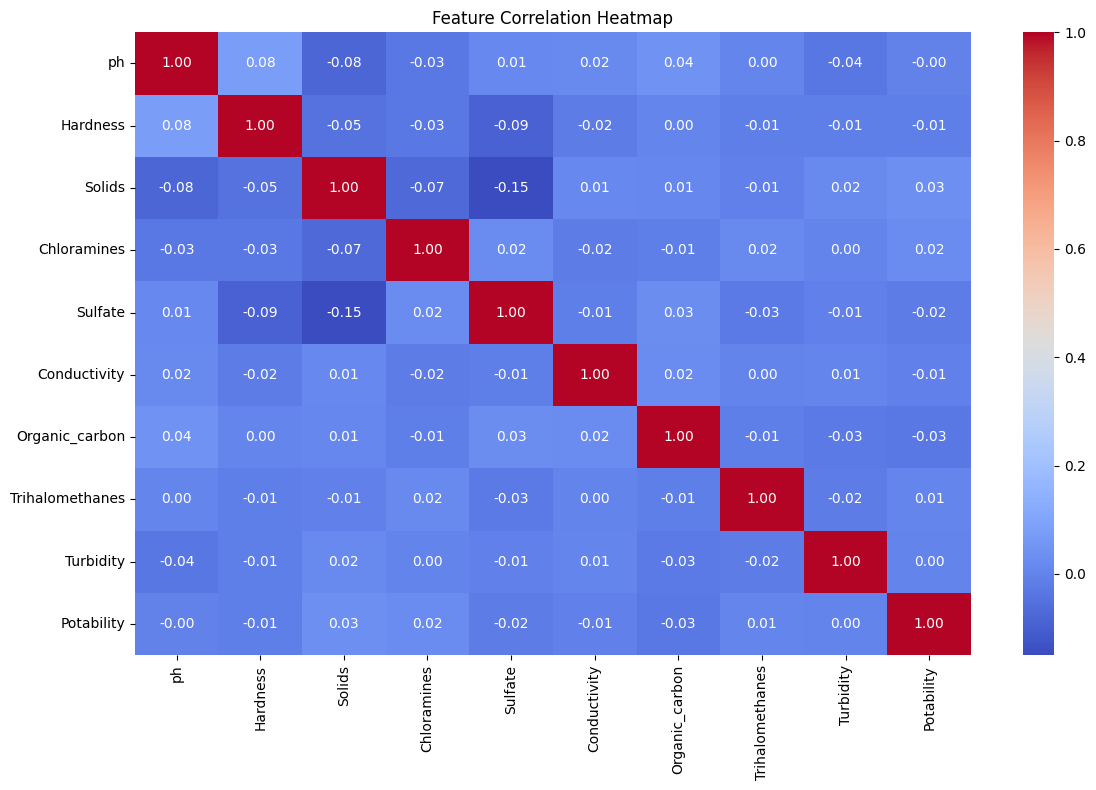

In [259]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(dataset.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [260]:
# ==============================
# 3. Data Preprocessing
# ==============================
X = dataset.drop('Potability', axis=1)
Y = dataset['Potability']

In [261]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [262]:
# Train-Test Split
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [263]:
# Class Distribution
print("Class distribution in training data:")
print(Y_train.value_counts())

Class distribution in training data:
Potability
0    1381
1     912
Name: count, dtype: int64


In [264]:
# ==============================
# 4. Handling Class Imbalance
# ==============================
# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)

In [265]:
# Compute Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_res), y=Y_train_res)
class_weight_dict = dict(enumerate(class_weights))

In [266]:
# ==============================
# 5. Model Definition
# ==============================
def john_akech():
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_res.shape[1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [267]:
# ==============================
# 6. Model Compilation
# ==============================
model = john_akech()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [268]:
# ==============================
# 7. Callbacks Setup
# ==============================
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [269]:
# ==============================
# 8. Model Training
# ==============================
history = model.fit(
    X_train_res, Y_train_res,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

Epoch 1/100
87/87 - 3s - 36ms/step - accuracy: 0.5141 - loss: 0.9804 - val_accuracy: 0.4236 - val_loss: 0.8108 - learning_rate: 0.0010
Epoch 2/100
87/87 - 0s - 4ms/step - accuracy: 0.5170 - loss: 0.8939 - val_accuracy: 0.4216 - val_loss: 0.8070 - learning_rate: 0.0010
Epoch 3/100
87/87 - 1s - 7ms/step - accuracy: 0.5286 - loss: 0.8348 - val_accuracy: 0.4481 - val_loss: 0.7802 - learning_rate: 0.0010
Epoch 4/100
87/87 - 1s - 7ms/step - accuracy: 0.5351 - loss: 0.8058 - val_accuracy: 0.4603 - val_loss: 0.7597 - learning_rate: 0.0010
Epoch 5/100
87/87 - 0s - 4ms/step - accuracy: 0.5268 - loss: 0.7836 - val_accuracy: 0.4827 - val_loss: 0.7502 - learning_rate: 0.0010
Epoch 6/100
87/87 - 1s - 7ms/step - accuracy: 0.5373 - loss: 0.7671 - val_accuracy: 0.5153 - val_loss: 0.7375 - learning_rate: 0.0010
Epoch 7/100
87/87 - 1s - 7ms/step - accuracy: 0.5427 - loss: 0.7504 - val_accuracy: 0.5397 - val_loss: 0.7292 - learning_rate: 0.0010
Epoch 8/100
87/87 - 1s - 6ms/step - accuracy: 0.5474 - loss: 

In [270]:
# ==============================
# 9. Model Evaluation and Metrics
# ==============================
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.6281
Test Accuracy: 0.6240


In [271]:
# Predictions
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [272]:
# Classification Report
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       307
           1       0.50      0.55      0.52       185

    accuracy                           0.62       492
   macro avg       0.61      0.61      0.61       492
weighted avg       0.63      0.62      0.63       492



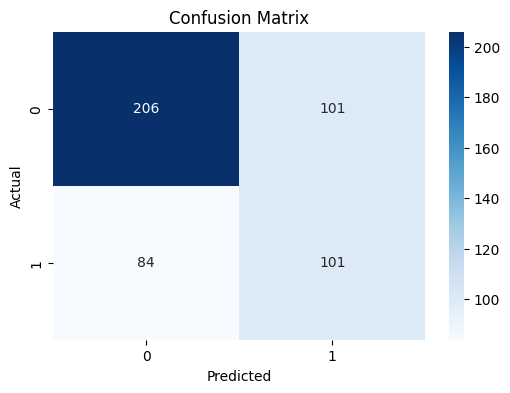

In [273]:
# ==============================
# 10. Visualization of Results
# ==============================
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


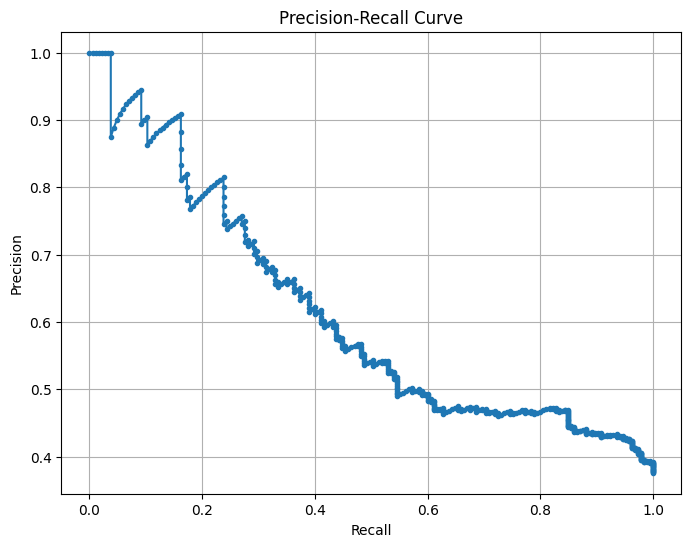

In [274]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test, model.predict(X_test))
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

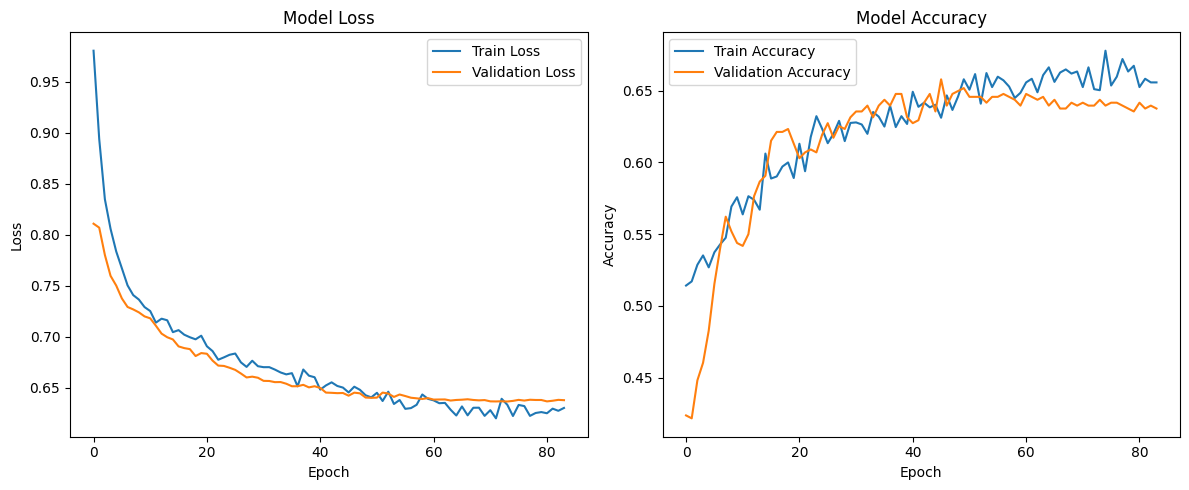

In [275]:
# ==============================
# 11. Training History
# ==============================
# Plot Training & Validation Accuracy Values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss Values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [276]:
# ==============================
# 12. Summary Table
# ==============================
summary_data = {
    'Regularizer': ['L2 Regularization (0.001)'],  # Regularizer used
    'Optimizer': ['Adam'],  # Optimizer used
    'Early Stopping': ['Patience=10, Monitor=val_loss'],  # Early Stopping criteria
    'Dropout Rate': ['0.5 (2 Dropout Layers)'],  # Dropout Rate applied
    'Accuracy': [round(accuracy, 4)],  # Accuracy on the test set
    'F1 Score': [round(f1_score(Y_test, Y_pred), 4)],  # F1 Score
    'Recall': [round(recall_score(Y_test, Y_pred), 4)]  # Recall
}

summary_df = pd.DataFrame(summary_data)
print("\nModel Summary Table:")
print(summary_df)


Model Summary Table:
                 Regularizer Optimizer                 Early Stopping  \
0  L2 Regularization (0.001)      Adam  Patience=10, Monitor=val_loss   

             Dropout Rate  Accuracy  F1 Score  Recall  
0  0.5 (2 Dropout Layers)     0.624     0.522  0.5459  
